In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    # for filename in filenames:
    #     print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Dataset Description
The competition data comprises over fifty anonymized health characteristics linked to three age-related conditions. Your goal is to predict whether a subject has or has not been diagnosed with one of these conditions -- a binary classification problem.

Note that this is a Code Competition, in which the actual test set is hidden. In this version, we give some sample data in the correct format to help you author your solutions. When your submission is scored, this example test data will be replaced with the full test set. There are about 400 rows in the full test set.

# Files and Field Descriptions
train.csv - The training set.

Id Unique identifier for each observation.

AB-GL Fifty-six anonymized health characteristics. All are numeric except for EJ, which is categorical.

Class A binary target: 1 indicates the subject has been diagnosed with one of the three conditions, 0 indicates they have not.

test.csv - The test set. Your goal is to predict the probability that a subject in this set belongs to each of the two classes.

greeks.csv - Supplemental metadata, only available for the training set.
Alpha Identifies the type of age-related condition, if present.

- A No age-related condition. Corresponds to class 0.

- B, D, G The three age-related conditions. Correspond to class 1.

- Beta, Gamma, Delta Three experimental characteristics.

- Epsilon The date the data for this subject was collected. 

Note that all of the data in the test set was collected after the training set was collected.

sample_submission.csv - A sample submission file in the correct format. 

See the Evaluation page for more details.

In [2]:
import numpy as np # linear algebra
import pandas as pd 
import mplcatppuccin
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


pal = mpl.style.use("mocha")

# Reading Data & Format

## Train & Test Data

In [3]:
def goRead(path):
    """read data"""
    file = pd.read_csv(path)
    return file



In [4]:
train = goRead("./train.csv")
test = goRead("./test.csv")
sample_submission = goRead("./sample_submission.csv")
greeks = goRead("./greeks.csv")

In [5]:
train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [6]:
print("Number of Train rows: {:,d}".format(train.shape[0]))
print("Columns:", ", ".join(train.columns))
print("-" * 100)
print("Number of Test rows: {:,d}".format(test.shape[0]))
print("Columns:", ", ".join(test.columns))

Number of Train rows: 617
Columns: Id, AB, AF, AH, AM, AR, AX, AY, AZ, BC, BD , BN, BP, BQ, BR, BZ, CB, CC, CD , CF, CH, CL, CR, CS, CU, CW , DA, DE, DF, DH, DI, DL, DN, DU, DV, DY, EB, EE, EG, EH, EJ, EL, EP, EU, FC, FD , FE, FI, FL, FR, FS, GB, GE, GF, GH, GI, GL, Class
----------------------------------------------------------------------------------------------------
Number of Test rows: 5
Columns: Id, AB, AF, AH, AM, AR, AX, AY, AZ, BC, BD , BN, BP, BQ, BR, BZ, CB, CC, CD , CF, CH, CL, CR, CS, CU, CW , DA, DE, DF, DH, DI, DL, DN, DU, DV, DY, EB, EE, EG, EH, EJ, EL, EP, EU, FC, FD , FE, FI, FL, FR, FS, GB, GE, GF, GH, GI, GL


In [7]:
print(" Train EJ column unique values:", train.EJ.unique())
print(" Test EJ column unique values:", test.EJ.unique())

 Train EJ column unique values: ['B' 'A']
 Test EJ column unique values: ['A']


In [8]:
def toBin(cols, dic):
    """
    Convert categorical column to binary representation using a dictionary mapping.

    This function takes a categorical column represented by `cols` and converts it to a binary representation based on
    the provided `dic` dictionary mapping. The dictionary maps categorical values to binary values (0 or 1).

    """
    cols = cols.map(dic)
    return cols


In [9]:
train["EJ"] = toBin(train["EJ"], {'A': 0, 'B': 1})
test["EJ"] = toBin(test["EJ"], {'A': 0, 'B': 1})

In [10]:
print("Null value in train data: ",train.isna().sum().any())
print("Null value in test data: ",test.isna().sum().any())

Null value in train data:  True
Null value in test data:  False


In [11]:
def fillNa(data, kol):
    """
    Fill null values in a specific column of a DataFrame with the median.

    This function fills null values in the specified column of the given DataFrame with the median value of that column.
    It modifies the DataFrame in-place and returns it.

    """
    median = data[kol].median()
    data[kol] = data[kol].fillna(median)
    return data

In [12]:
train_na = ['BQ', 'CB', 'CC', 'DU', 'EL', 'FC', 'FL', 'FS', 'GL']
for x in train_na:
    fillNa(train, x) 


In [13]:
print("Null value in train data: ",train.isna().sum().any())

Null value in train data:  False


In [14]:
print("Duplicated in train data: ",train.duplicated().sum().any())
print("Duplicated in train data: ",train.duplicated().sum().any())

Duplicated in train data:  False
Duplicated in train data:  False


# Lets Explore

In [15]:
def plot_class_distribution(data):
    """Plot the class distribution of a dataset.

    This function takes a dataset as input and generates a bar plot and a pie plot to visualize the class distribution.
    The bar plot displays the count of each class, and the pie plot displays the percentage distribution of each class.

    """
    # Count the occurrences of each class
    class_counts = data['Class'].value_counts()

    # Calculate percentages
    percentages = class_counts.values / class_counts.sum() * 100

    # Combine class labels with percentages
    labels_with_percentages = list(zip(class_counts.index, percentages))

    # Define the explode values
    explode = [0.1] * len(class_counts)  # Modify the values as per your preference

    # Create a bar plot and a pie plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Bar plot
    sns.barplot(ax=axes[0], x=class_counts.index, y=class_counts.values, color=pal)
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Class Distribution')

    # Pie plot
    axes[1].pie(class_counts.values, labels=labels_with_percentages, autopct='%1.1f%%', startangle=90, explode=explode)
    axes[1].set_title('Class Distribution')

    plt.show()

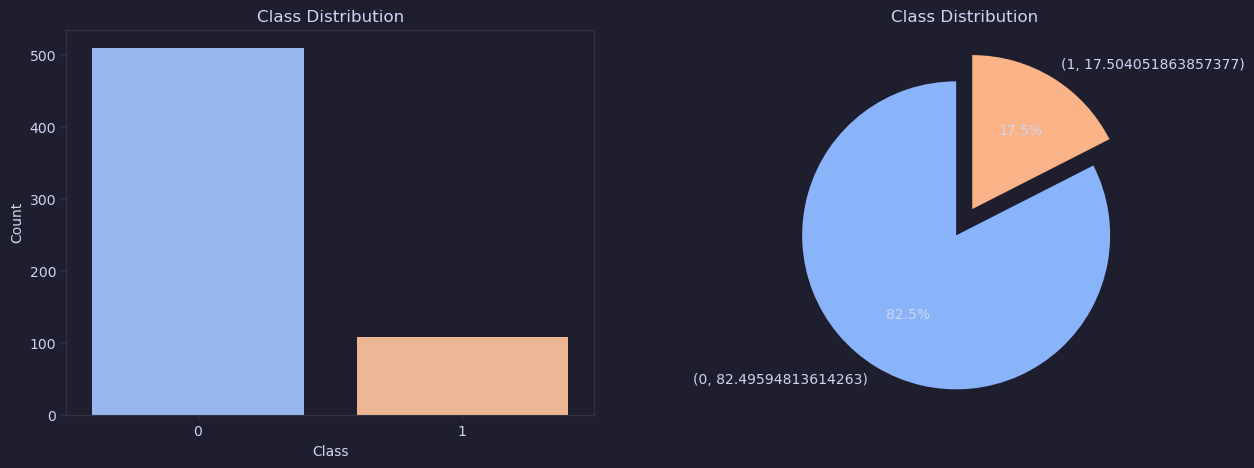

In [16]:
 #Check label/target distribution 
 plot_class_distribution(train)

In [17]:
def showFig(listx):
    """
    Display KDE plots for each element in a list.

    This function generates subplots to display KDE (Kernel Density Estimation) plots for each element in the given list.
    The plots are arranged in a 3x3 grid.

    """
    fig, axes = plt.subplots(8, 7, figsize=(20, 30))
    
    # Adjust padding between subplots
    fig.subplots_adjust(hspace=0.5, wspace=0.3)
    
    for i, x in enumerate(listx):
        row = i // 7  # Calculate the row index based on the iteration
        col = i % 7  # Calculate the column index based on the iteration
        
        sns.kdeplot(ax=axes[row, col], x=x, hue='Class', data=train, fill=True)
    
    plt.show()

In [18]:
features = [
    'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
    'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
    'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
    'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
    'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL'
]

label = ['Class']


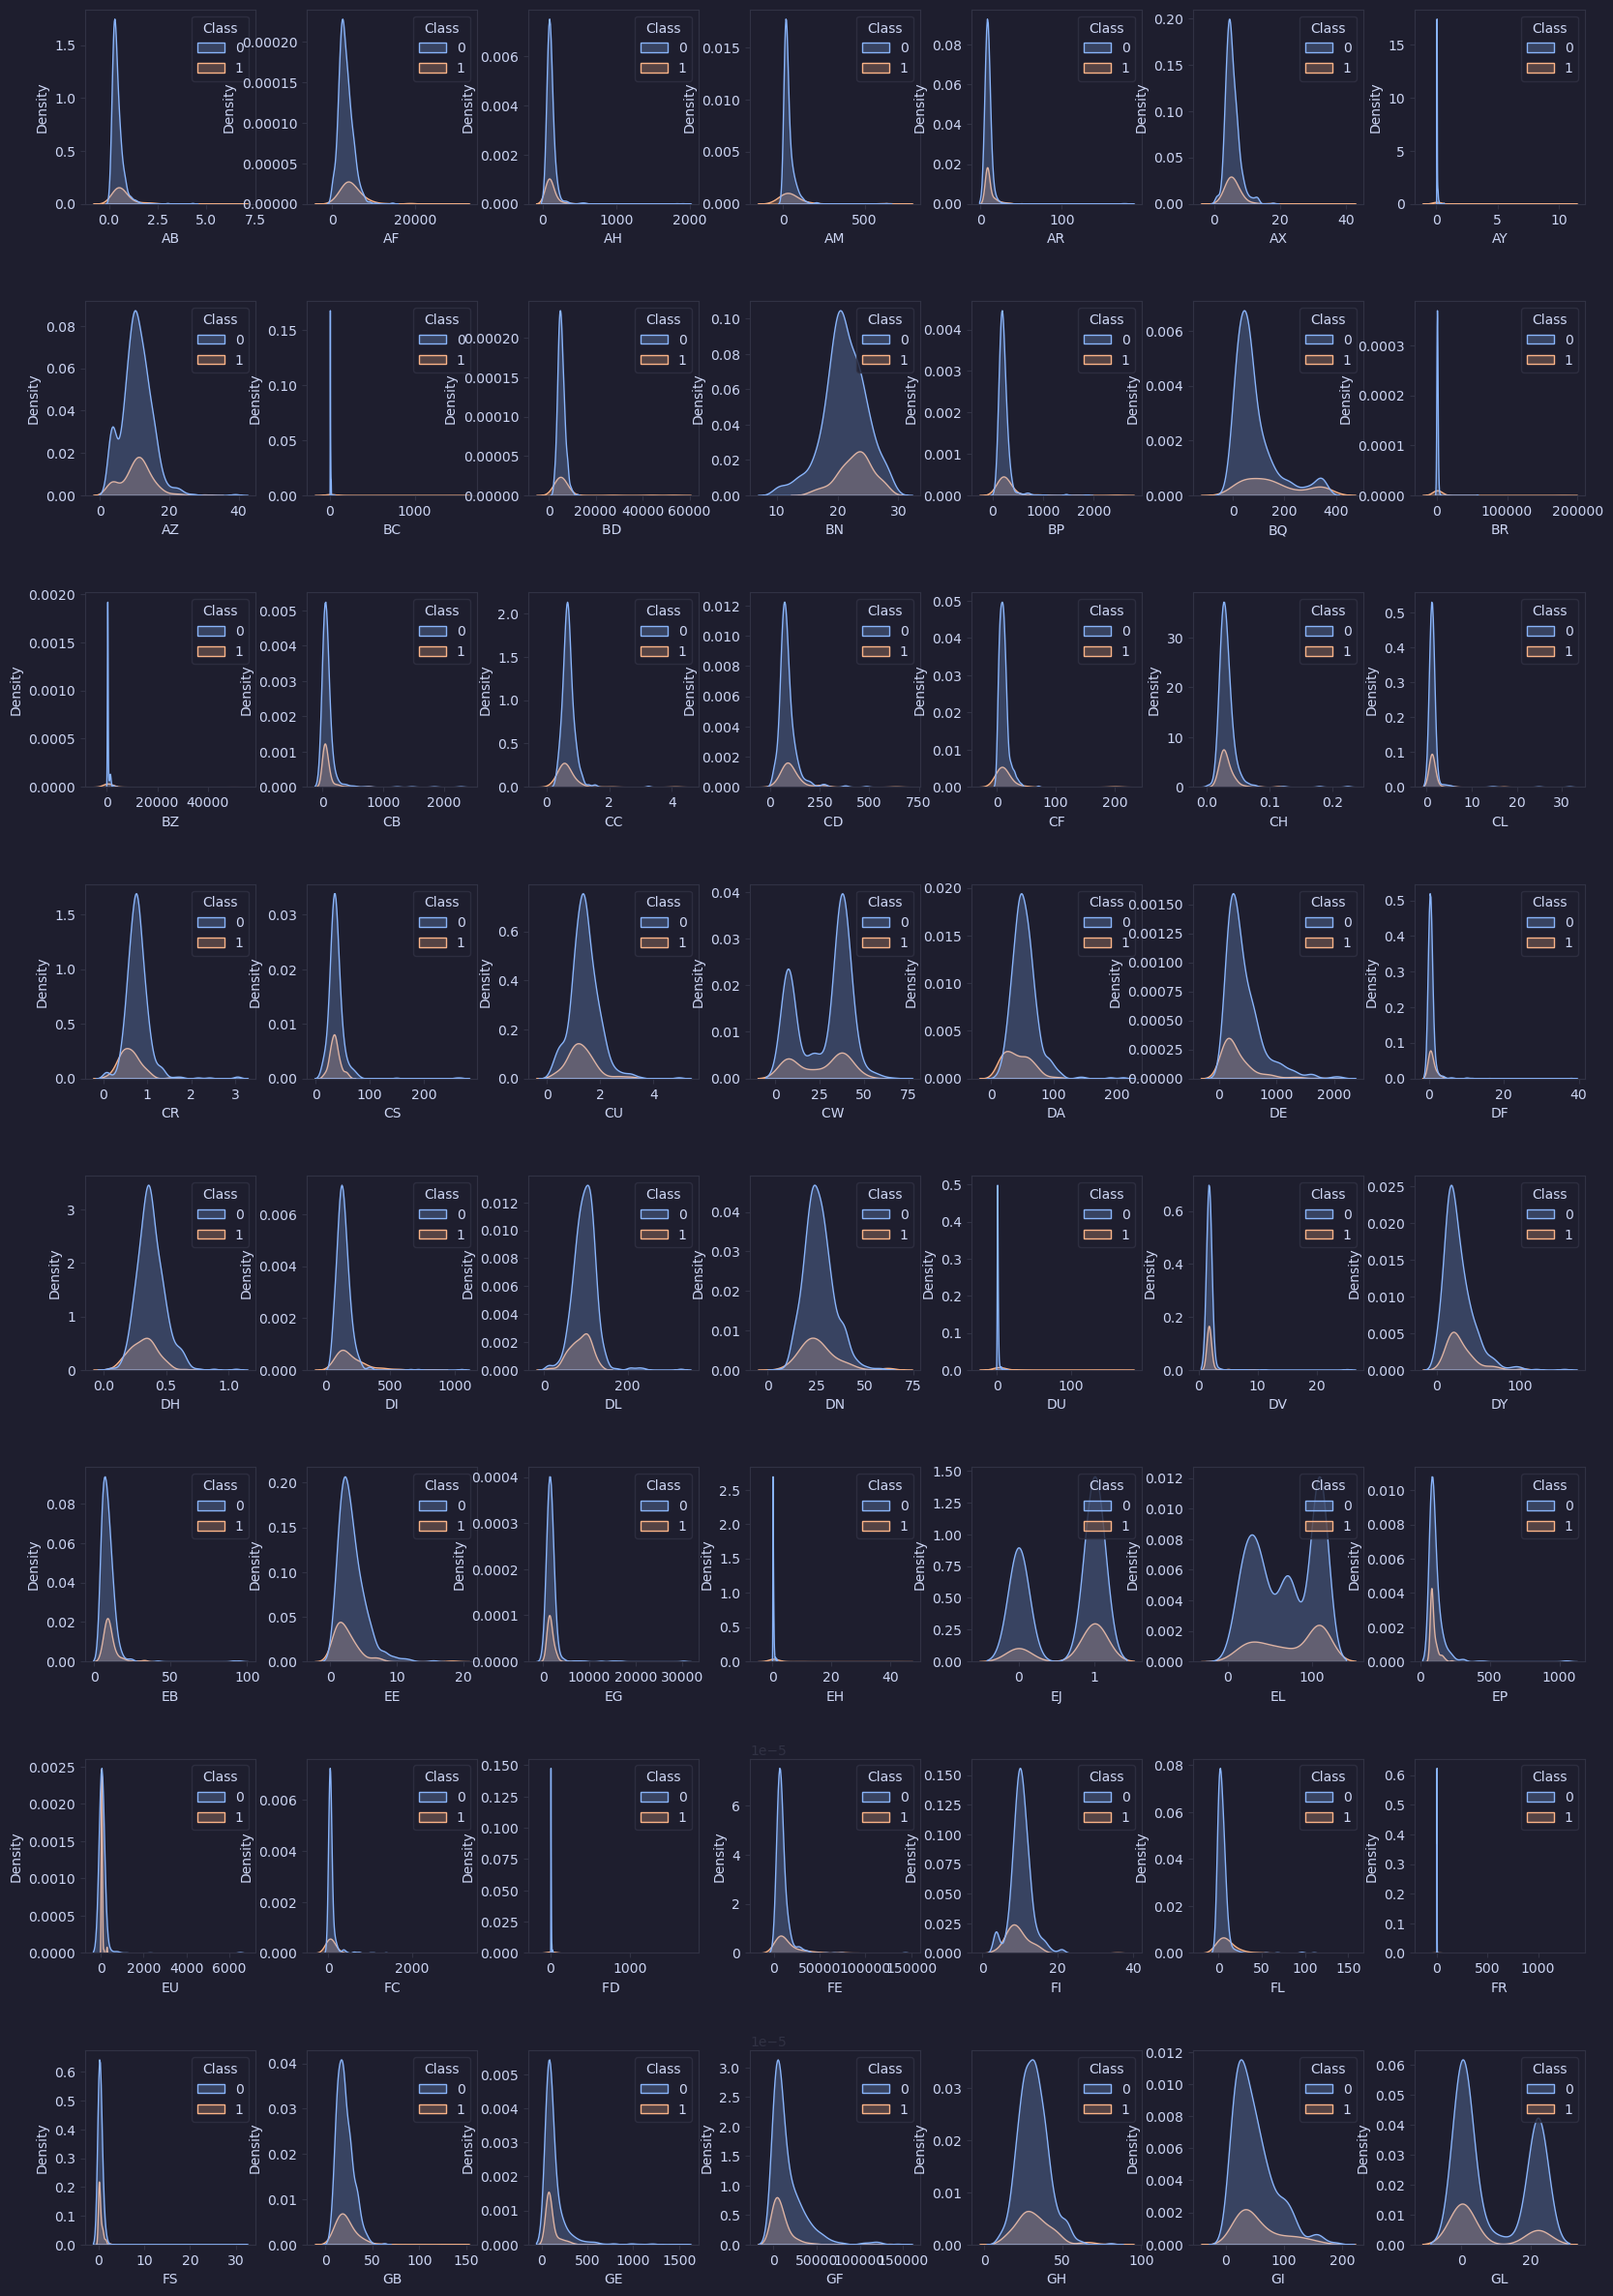

In [19]:
showFig(features)

In [20]:
train.describe().T.style.background_gradient(cmap=pal)

,count,mean,std,min,25%,50%,75%,max
AB,617.000000,0.477149,0.468388,0.081187,0.252107,0.354659,0.559763,6.161666
AF,617.000000,3502.013221,2300.322717,192.593280,2197.345480,3120.318960,4361.637390,28688.187660
AH,617.000000,118.624513,127.838950,85.200147,85.200147,85.200147,113.739540,1910.123198
AM,617.000000,38.968552,69.728226,3.177522,12.270314,20.533110,39.139886,630.518230
AR,617.000000,10.128242,10.518877,8.138688,8.138688,8.138688,8.138688,178.943634
AX,617.000000,5.545576,2.551696,0.699861,4.128294,5.031912,6.431634,38.270880
AY,617.000000,0.060320,0.416817,0.025578,0.025578,0.025578,0.036845,10.315851
AZ,617.000000,10.566447,4.350645,3.396778,8.129580,10.461320,12.969516,38.971568
BC,617.000000,8.053012,65.166943,1.229900,1.229900,1.229900,5.081244,1463.693448
BD,617.000000,5350.388655,3021.326641,1693.624320,4155.702870,4997.960730,6035.885700,53060.599240


In [21]:
def visualize_correlation(data, cbar_width=0.05):
    """Create a correlation matrix visualization.

    This function takes a pandas DataFrame as input and generates a correlation matrix using the .corr() function.
    The correlation matrix is then visualized using a heatmap plot from seaborn, with a resizable colorbar.

    """
    # Calculate the correlation matrix
    corr_matrix = data.corr()

    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create the heatmap using seaborn's heatmap function
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5, ax=ax)

    # Set the title of the plot
    ax.set_title('Correlation Matrix')

    # Get the current position and size of the colorbar axes
    cbar = ax.collections[0].colorbar
    cbar_position = cbar.ax.get_position()

    # Set the width of the colorbar to the desired size
    cbar.ax.set_position([cbar_position.x0, cbar_position.y0, cbar_width, cbar_position.height])

    # Show the plot
    plt.show()

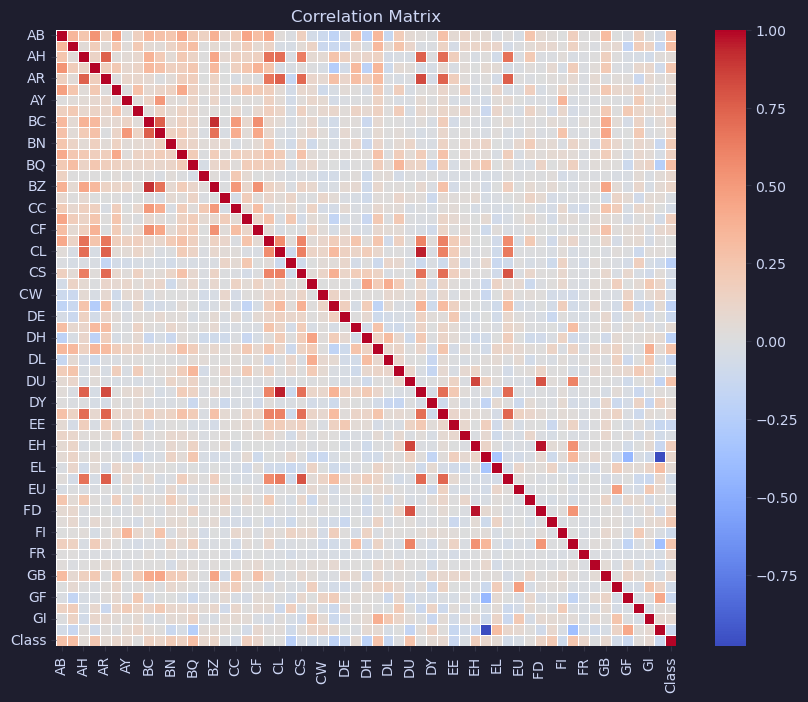

In [22]:
visualize_correlation(train, cbar_width=0.05)

# Modelling

## Select target and model

### Naive Bayes

In [23]:
import sklearn.model_selection as ms 
import sklearn.naive_bayes as nb 
import sklearn.metrics as met  
import sklearn.ensemble as ensemble
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [24]:
X = train[features]
Y = train[label]

In [30]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [31]:
# MODELING

# Split data into train and test sets for Gaussian Naive Bayes
def split_data(features, label):
    split = ms.train_test_split(features, label, test_size=0.25, random_state=0)
    return split

In [32]:
X_train, X_test, y_train, y_test = split_data(X_scaled, train[label])

#### Classifier

In [33]:
#Gaussian
# gnb = nb.GaussianNB()
# multi_nb.fit(X_train, y_train)

# # #Bernoulli 
# # bernoulli_nb = BernoulliNB()
# # bernoulli_nb.fit(X_train, y_train)

# # #MultiNomial
multi_nb = MultinomialNB()
multi_nb.fit(X_train, y_train)



MultinomialNB()

In [ ]:
y_prediction = multi_nb.predict_proba(X_train)
boosted = ensemble.GradientBoostingClassifier()
boosted.fit(y_prediction, y_train)

boost_test = multi_nb.predict_proba(X_test)
y_boost_pred = boosted.predict(boost_test)

accuracy = met.accuracy_score(y_test, y_boost_pred)
print("-"*60)
print("This is Classification report of Boost Gaussian Naive Bayes:")
print(classification_report(y_test, y_boost_pred))
print("-"*60)
print('Accuracy =', accuracy)
print("-"*60)
    



------------------------------------------------------------
This is Classification report of Boost Gaussian Naive Bayes:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       131
           1       0.41      0.46      0.43        24

    accuracy                           0.81       155
   macro avg       0.65      0.67      0.66       155
weighted avg       0.82      0.81      0.82       155

------------------------------------------------------------
Accuracy = 0.8129032258064516
------------------------------------------------------------


In [ ]:
train['Class'].value_counts()

0    509
1    108
Name: Class, dtype: int64

# Submitting

In [ ]:
# sample_submission.head()

In [ ]:
test[features]

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
sample_submission

,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5
2,02fa521e1838,0.5,0.5
3,040e15f562a2,0.5,0.5
4,046e85c7cc7f,0.5,0.5


In [ ]:
pred_submission = multi_nb.predict_proba(test[features])
submission = boosted.predict_proba(pred_submission)

In [ ]:
sample_submission[['class_0', 'class_1']] = submission
sample_submission

,Id,class_0,class_1
0,00eed32682bb,0.86302,0.13698
1,010ebe33f668,0.86302,0.13698
2,02fa521e1838,0.86302,0.13698
3,040e15f562a2,0.86302,0.13698
4,046e85c7cc7f,0.86302,0.13698


In [ ]:
sample_submission.to_csv('./submission.csv')